In [7]:
# load Ames data into pandas dataframe

import pandas as pd

columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area', 'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv( 'http://jse.amstat.org/v19n3/decock/AmesHousing.txt', sep='\t', usecols=columns)

df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [8]:
df.shape

(2930, 6)

In [9]:
df['Central Air'] = df['Central Air'].map({ 'N' : 0, 'Y' : 1})

In [10]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [11]:
# remove missing value row

df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

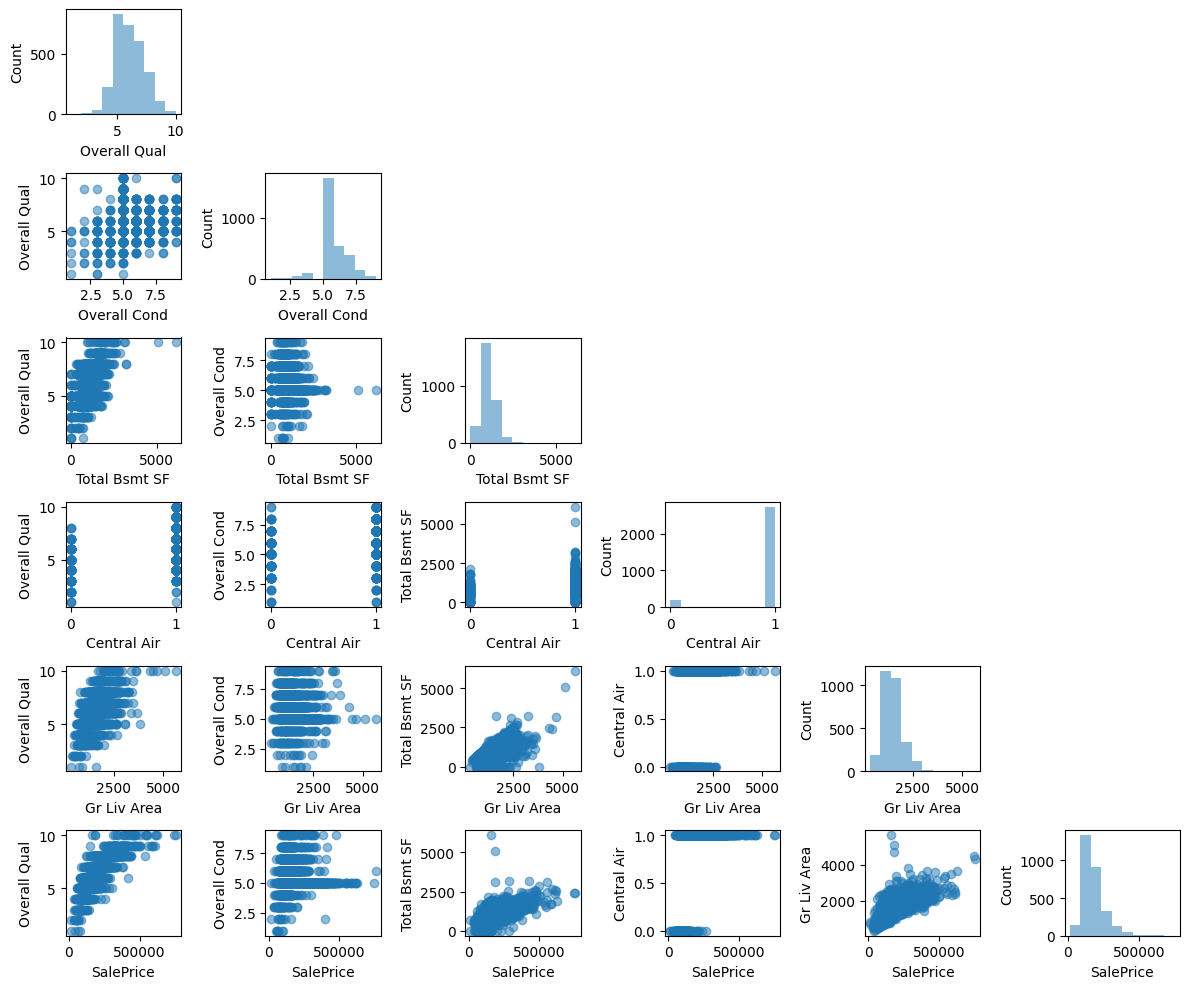

In [12]:
# create scatter plot matrix of pair-wise correlations

import matplotlib.pyplot as plt

from mlxtend.plotting import scatterplotmatrix

scatterplotmatrix( df.values, figsize=(12, 10), names=df.columns, alpha=0.5)

plt.tight_layout()

plt.show()

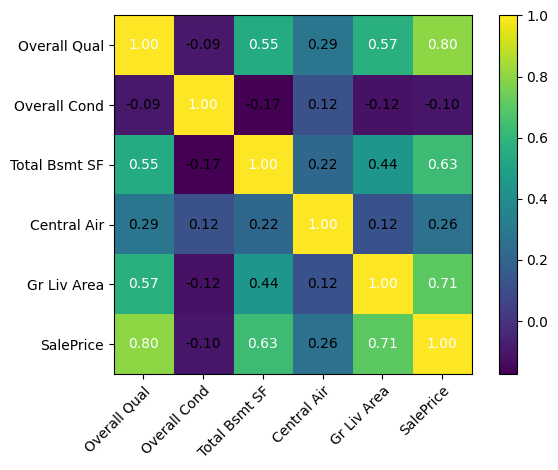

In [13]:
# plot correlation matrix as heatmap

import numpy as np
from mlxtend.plotting import heatmap

cm = np.corrcoef(df.values.T)
hm = heatmap( cm, row_names=df.columns, column_names=df.columns )
plt.tight_layout()
plt.show()

In [14]:
# LinearRegressionGD

class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return self.net_input(X)

In [15]:
# use GR Living Area and standardize variables for better convergence

X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

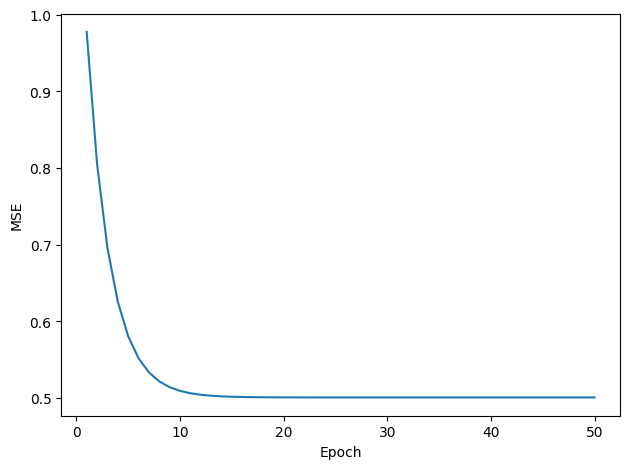

In [16]:
# plot loss of function relative to epochs

plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
#plt.savefig('figures/09_06.png', dpi=300)
plt.show()

In [17]:
# helper function to plot scatterplot of training examples and add regression line
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

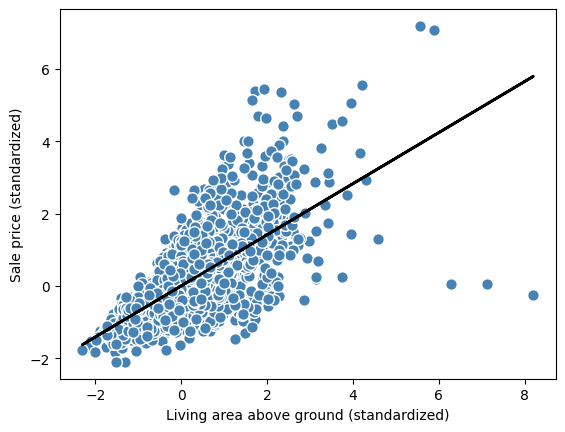

In [18]:
# plot living area against sale price

lin_regplot(X_std, y_std, lr)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')

#plt.savefig('figures/09_07.png', dpi=300)
plt.show()

In [19]:
# scale predicted price bac onto original price
feature_std = sc_x.transform(np.array([[2500]]))
target_std  = lr.predict( feature_std )
target_reverted = sc_y.inverse_transform( target_std.reshape(-1, 1) )
print(f'Sales price: {target_reverted.flatten()[0]:.2f}')

Sales price: 292507.07


In [20]:
# don't have to update bias unit if working with standardized variables, since y axis is always 0

print(f'Slope: {lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


In [21]:
# using GD with sklearn

from sklearn.linear_model import LinearRegression

slr = LinearRegression()

slr.fit(X, y)

y_pred = slr.predict( X )

print(f'Slope: {slr.coef_[0]:.3f}')

print(f'Intercept: {slr.intercept_:.3f}')

Slope: 111.666
Intercept: 13342.979


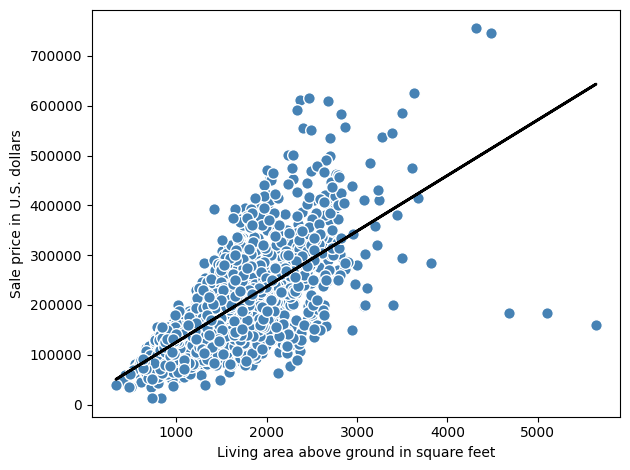

In [22]:
# compare with our own GD implementation, and see it fits data well

lin_regplot(X, y, slr)

plt.xlabel('Living area above ground in square feet')

plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()

plt.show()

In [23]:
# Use linear model with RANSAC algorithm from sklearn

from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor( LinearRegression(), max_trials=100, min_samples=0.95, residual_threshold=None, random_state=123 )

ransac.fit( X, y )

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

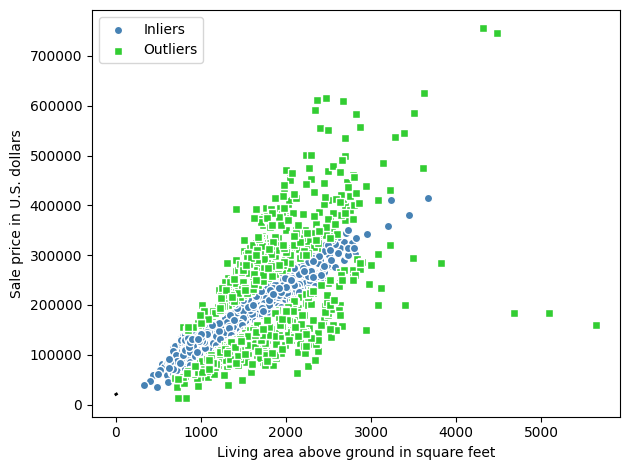

In [24]:
# obtain inliers and outliers from RANSAC and plot with linear fit

inlier_mask = ransac.inlier_mask_

outlier_mask = np.logical_not( inlier_mask )

line_X = np.arange( 3, 10, 1 )

line_y_ransac = ransac.predict( line_X[ :, np.newaxis ] )

plt.scatter(X[inlier_mask], y[inlier_mask], c='steelblue', edgecolor='white', marker='o', label='Inliers' )
plt.scatter(X[outlier_mask], y[outlier_mask], c='limegreen', edgecolor='white', marker='s', label='Outliers')

plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

plt.legend(loc='upper left')

plt.tight_layout()

plt.show()

In [25]:
# slope and intercept different from previous section without RANSAC

print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')

print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


In [26]:
def mean_absolute_deviation( data ):
    return np.mean( np.abs( data - np.mean(data) ) )

mean_absolute_deviation(y)

58269.561754979375

In [27]:
# use all five features of dataset and train multiple regression model

from sklearn.model_selection import train_test_split

target = 'SalePrice'

features = df.columns[ df.columns != target ]

X = df[ features ].values
y = df[ target   ].values 

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=123 )

slr = LinearRegression()

slr.fit( X_train, y_train )

y_train_pred = slr.predict( X_train )
y_test_pred  = slr.predict( X_test  )

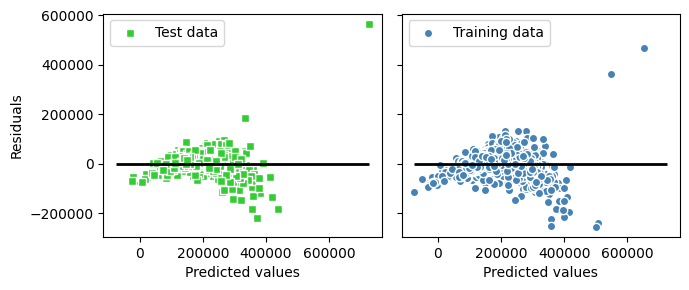

In [28]:
# Visualize Residual plot - difference/distance between actual and predicted values

x_max = np.max( [ np.max( y_train_pred ), np.max( y_test_pred ) ] )
x_min = np.min( [ np.min( y_train_pred) , np.min( y_test_pred ) ] )

fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(7, 3), sharey=True )

ax1.scatter( y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')

ax2.scatter( y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')

ax1.set_ylabel( 'Residuals' )

for ax in ( ax1, ax2 ):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min - 100, xmax=x_max + 100, color='black', lw=2)

plt.tight_layout()
plt.show()

In [29]:
# Compute MSE for training and test predictions

from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error( y_train, y_train_pred )

mse_test = mean_squared_error( y_test, y_test_pred )

print(f'MSE train: {mse_train:.2f}')

print(f'MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


In [30]:
# compute Mean Square Absolute Error (MAE)

from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error( y_train, y_train_pred)

mae_test = mean_absolute_error( y_test, y_test_pred )

print(f'MAE train: {mae_train:.3f}')

print(f'MAE Test: {mae_test: .3f}')

MAE train: 25983.027
MAE Test:  24921.289
